In [102]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/HW2-DL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/HW2-DL


##**Libraries**

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import torch 
from PIL import Image
from torch import nn, save, load
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn import preprocessing


##**Loading data and show 10 last rows**

In [104]:
df = pd.read_csv("./Data/HW2_data/international_matches.csv") 

In [105]:
df.tail(10)

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23911,2022-06-14,Ukraine,Republic of Ireland,Europe,Europe,27,47,1535,1449,1,...,No,Draw,75.0,75.0,74.8,78.7,80.0,76.5,72.7,73.8
23912,2022-06-14,Bosnia and Herzegovina,Finland,Europe,Europe,59,57,1388,1406,3,...,No,Win,76.0,83.0,74.2,77.0,78.0,70.0,72.3,73.5
23913,2022-06-14,Romania,Montenegro,Europe,Europe,48,70,1446,1342,0,...,No,Lose,77.0,65.0,73.5,73.7,75.0,76.2,74.7,68.2
23914,2022-06-14,Luxembourg,Faroe Islands,Europe,Europe,94,124,1229,1137,2,...,No,Draw,69.0,NaN,68.5,NaN,69.8,NaN,NaN,NaN
23915,2022-06-14,Turkey,Lithuania,Europe,Europe,43,138,1461,1092,2,...,No,Win,79.0,71.0,78.2,76.7,78.2,NaN,NaN,NaN
23916,2022-06-14,Moldova,Andorra,Europe,Europe,180,153,932,1040,2,...,No,Win,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23917,2022-06-14,Liechtenstein,Latvia,Europe,Europe,192,135,895,1105,0,...,No,Lose,NaN,65.0,NaN,NaN,NaN,NaN,NaN,NaN
23918,2022-06-14,Chile,Ghana,South America,Africa,28,60,1526,1387,0,...,Yes,Lose,79.0,74.0,75.5,76.7,78.2,75.5,76.0,78.2
23919,2022-06-14,Japan,Tunisia,Asia,Africa,23,35,1553,1499,0,...,No,Lose,73.0,NaN,75.2,75.0,77.5,70.8,72.3,74.0
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


##**Scatter of data**

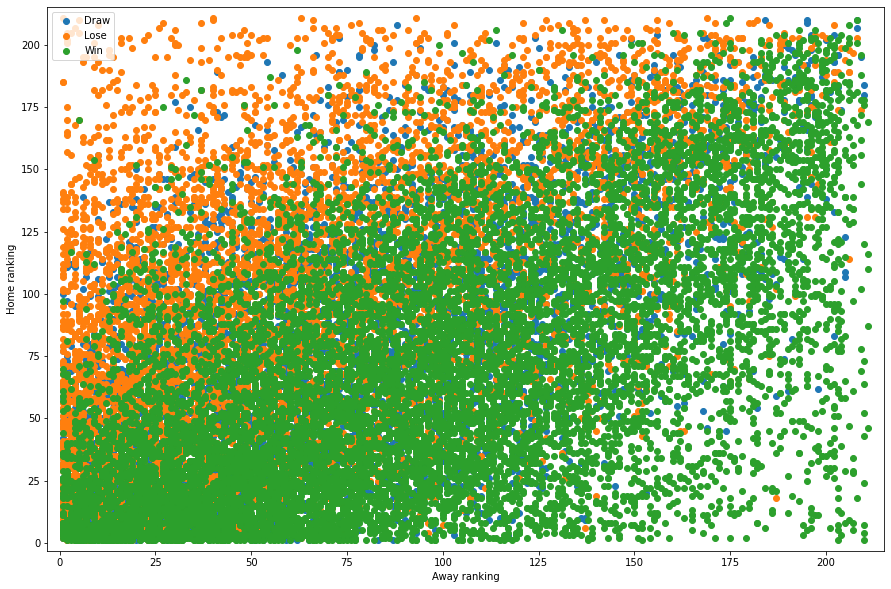

In [106]:
groups = df.groupby('home_team_result')

# Plot
fig = plt.figure(figsize=(15, 10))
fig.add_subplot(1, 1, 1)
plt.margins(0.02)
for name, group in groups:
    plt.plot( group.away_team_fifa_rank,group.home_team_fifa_rank, marker='o', linestyle='', label=name)
plt.legend()
plt.xlabel('Away ranking')
plt.ylabel('Home ranking')
plt.show()

##**ُSpliting and removing zero**

In [107]:
print(df.shape)
df.drop(df[df['away_team_total_fifa_points']==0].index, inplace = True)
df.drop(df[df['home_team_total_fifa_points']==0].index, inplace = True)
print(df.shape)

(23921, 25)
(9594, 25)


In [108]:
x_cols = df[['home_team_total_fifa_points', 'away_team_total_fifa_points','home_team_fifa_rank','away_team_fifa_rank']]
X_train, X_test, y_train, y_test= train_test_split(x_cols,df['home_team_result'], test_size=0.25, random_state=42, shuffle=True)


##**Find corrolation**

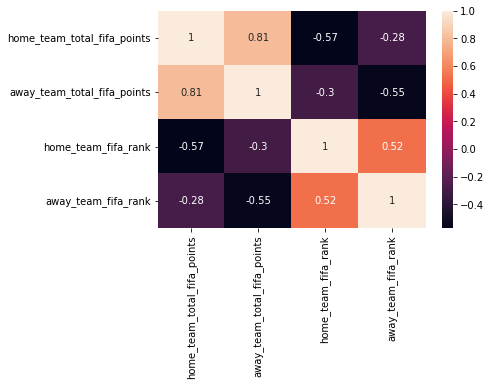

In [109]:
x_corr = df[['home_team_total_fifa_points','away_team_total_fifa_points','home_team_fifa_rank','away_team_fifa_rank','home_team_result']]
sns.heatmap(x_corr.corr(), annot=True)
plt.show()

##**Data loader**

In [110]:
batch_size=64

In [111]:
le = preprocessing.LabelEncoder()
targets = le.fit_transform(y_train)
train_target = torch.tensor(targets)
train = torch.tensor(X_train.values.astype(np.float32)) 
train_tensor = torch.utils.data.TensorDataset(train, train_target) 
train_loader =  torch.utils.data.DataLoader(dataset = train_tensor, batch_size = batch_size, shuffle = True)

In [113]:
targets = le.fit_transform(y_test)
test_target = torch.tensor(targets)
test = torch.tensor(X_test.values.astype(np.float32)) 
test_tensor = torch.utils.data.TensorDataset(test, test_target) 
test_loader =  torch.utils.data.DataLoader(dataset = test_tensor, batch_size = batch_size, shuffle = False)

##**Defining FC network**

In [114]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3, num_classes):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.relu = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size1) 
        self.l2 = nn.Linear(hidden_size1, hidden_size2) 
        self.l3 = nn.Linear(hidden_size2, hidden_size3) 
        self.lFilnal = nn.Linear(hidden_size3, num_classes)  
    
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        out = self.relu(out)
        out = self.l3(out)
        out = self.relu(out)
        out = self.lFilnal(out)
        return out

In [160]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [180]:
model = NeuralNet(4,10,20,8 ,3).to(device)

In [181]:
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

##**Training**##


In [182]:
n_total_steps = len(train_loader)
# enumerate epochs
for epoch in range(10):
    # enumerate mini batches
    for i, (inputs, targets) in enumerate(train_loader):
      # clear the gradients
      optimizer.zero_grad()
      # compute the model output
      yhat = model(inputs)
      # calculate loss
      loss = criterion(yhat, targets)
      # credit assignment
      loss.backward()
      # update model weights
      optimizer.step()
      if (i+1) % 64 == 0:
        print (f'Epoch [{epoch+1}/{10}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

Epoch [1/10], Step [64/113], Loss: 0.9506
Epoch [2/10], Step [64/113], Loss: 1.0619
Epoch [3/10], Step [64/113], Loss: 0.9523
Epoch [4/10], Step [64/113], Loss: 0.9910
Epoch [5/10], Step [64/113], Loss: 0.9245
Epoch [6/10], Step [64/113], Loss: 0.8967
Epoch [7/10], Step [64/113], Loss: 0.8849
Epoch [8/10], Step [64/113], Loss: 0.9853
Epoch [9/10], Step [64/113], Loss: 0.8853
Epoch [10/10], Step [64/113], Loss: 0.9213


In [183]:
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in test_loader:
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the test: {acc} %')

Accuracy of the test: 56.48186744476865 %


In [184]:
englandPoints = 1728.47
iranPoints = 1564.61
walesPoints = 1569.82
usaPoints = 1627.48
englanRanking = 5
iranRanking = 20
walesRanking = 19
usaRanking = 16

In [185]:
print(le.transform(["Win", "Lose", "Draw"]))

[2 1 0]


In [186]:
def whichWin(yPred):
  if(yPred==1):
    print("Model predicts that Iran win")
  elif(yPred==0):
    print("Model predicts draw")
  elif(yPred==2):
    print("Model predicts that other country win")
    

In [187]:
test1 = torch.tensor([walesPoints,iranPoints,walesRanking,iranRanking])
test2 = torch.tensor([usaPoints, iranPoints,usaRanking,iranRanking])
test3 = torch.tensor([englandPoints,iranPoints,englanRanking, iranRanking])
yPred = model(test1).argmax()
print("Iran ------ Wales")
whichWin(yPred)
print("\n\n")
yPred = model(test2).argmax()
print("Iran ------ USA")
whichWin(yPred)
print("\n\n")
yPred = model(test3).argmax()
print("Iran ------ England")
whichWin(yPred)

Iran ------ Wales
Model predicts that other country win



Iran ------ USA
Model predicts that other country win



Iran ------ England
Model predicts that other country win
